In [58]:
import pandas as pd
%matplotlib inline

import os, json
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from keras import backend as K
K.set_image_dim_ordering('th')
import keras
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image
CURRENT_WORKING_DIR="~/Downloads/dogscats"


In [59]:
FILES_PATH = 'http://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')

with open(fpath) as f: class_dict=(json.load(f))
classes=[class_dict[str(i)][1] for i in range(0,len(class_dict))]
classes[:5]
    

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

In [60]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1] 

def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [61]:
model = VGG_16()
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 224, 224)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_27[0][0]           
___________________________________________________________________________________________

In [62]:
HOME_DIR='/Users/priya/Downloads/dogscats/sample/'
path=HOME_DIR

In [68]:
train_gen=image.ImageDataGenerator()

train_imgs=train_gen.flow_from_directory(path+'train', target_size=(224,224), 
                class_mode=None, shuffle=False, batch_size=15)

train_data=np.concatenate([train_imgs.next() for i in range(train_imgs.nb_sample)])


Found 16 images belonging to 2 classes.


In [70]:
valid_imgs=train_gen.flow_from_directory(path+'valid', target_size=(224,224), 
                class_mode=None, shuffle=False, batch_size=15)
valid_data=np.concatenate([valid_imgs.next() for i in range(valid_imgs.nb_sample)])


Found 8 images belonging to 2 classes.


In [91]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

train_labels=train_imgs.classes
valid_labels=valid_imgs.classes
train_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [93]:
train_imgs.filenames[0]

'cats/cat.3570.jpg'

In [13]:
model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(2, activation='softmax'))
model.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [78]:
from keras.optimizers import SGD, RMSprop, Adam

model.compile(keras.optimizers.Adam(lr=0.0001), 'categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit_generator(train_imgs,
                   samples_per_epoch = train_imgs.N ,
                    nb_epoch=1,
                   validation_data = valid_imgs, 
                  nb_val_samples = valid_imgs.N )



Epoch 1/1
16/16 [==============================] - 50s - loss: 1.3141 - acc: 0.3750 - val_loss: 0.6590 - val_acc: 0.7500


In [49]:
model.save_weights('finetune1.h5')
test_imgs=train_gen.flow_from_directory(path+'test', target_size=(224,224), 
                class_mode=None, shuffle=False, batch_size=15)

Found 29 images belonging to 1 classes.


In [46]:
preds=model.predict_generator(test_imgs, test_imgs.nb_sample)


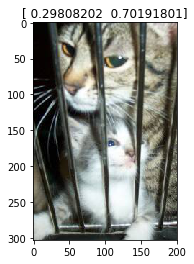

In [47]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def showImage(prob,filename):
    image = mpimg.imread(path+'test/'+filename)
    plt.imshow(image)
    plt.title(prob)
    plt.show()
    
showImage(preds[0],test_imgs.filenames[0])

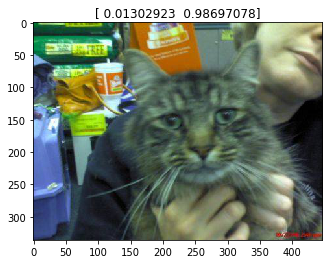

In [43]:
showImage(preds[2],test_imgs.filenames[2])

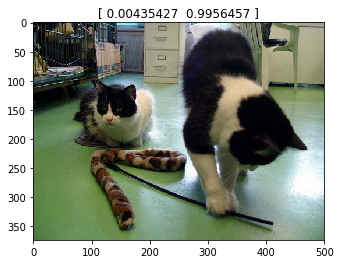

In [86]:
showImage(preds[7],test_imgs.filenames[7])